In [1]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Once data has finished processing, load data from folder structure
# text-data/
# ├─ advertisement/
# ├─ email/
# ├─ invoice/
# ....
data = load_files('../text-data', encoding='utf-8', decode_error='ignore')

X = data.data               
y = data.target             
class_names = data.target_names 

# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2]:
# vectorize text using TF-IDF
vectorizer = TfidfVectorizer(
    # this is all first pass so might want to update after check in
    # limit vocab
    max_features=5000,
    # ignore terms that appear in fewer than 2 documents     
    min_df=2,               
    # ignore terms that appear in more than 80% of documents
    max_df=0.8,
    # using unigrams and bigrams             
    ngram_range=(1, 2), 
    # removing common English words    
    stop_words='english'
)

X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

In [3]:
# train baseline Logistic Regression
base_model = LogisticRegression(max_iter=1000, random_state=42)
base_model.fit(X_train_vectors, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [4]:
# eval on test set
y_pred = base_model.predict(X_test_vectors)
print(f"Test Accuracy: {base_model.score(X_test_vectors, y_test)}\n")

print("Baseline Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

Test Accuracy: 0.7436708860759493

Baseline Classification Report:
                        precision    recall  f1-score   support

         advertisement       0.79      0.73      0.76       119
                budget       0.70      0.75      0.73        57
                 email       0.90      0.98      0.94       179
           file_folder       0.51      0.78      0.61        63
                  form       0.64      0.79      0.71       146
           handwritten       0.71      0.43      0.53        56
               invoice       0.83      0.62      0.71        55
                letter       0.75      0.83      0.79       213
                  memo       0.66      0.91      0.77       179
          news_article       0.77      0.79      0.78        70
                  note       0.67      0.13      0.22        45
          presentation       0.71      0.46      0.56        59
         questionnaire       0.96      0.66      0.78        70
                report       0.00   

c:\Users\maxiz\projects\school\CS4120\nlp_file_organizer\nlp_project\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\maxiz\projects\school\CS4120\nlp_file_organizer\nlp_project\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\maxiz\projects\school\CS4120\nlp_file_organizer\nlp_project\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter

In [5]:
# tuning with grid search

# chains vectorizer and model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

param_grid = {
    # max vocab size
    'tfidf__max_features': [3000, 5000, 7000],
    # unigrams only, unigrams + bigrams, unigrams + bigrams + trigrams
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    # min document frequency - removes rare words
    'tfidf__min_df': [2, 3, 5],
    # max document frequency - removes common words
    'tfidf__max_df': [0.7, 0.8, 0.9],
    # inverse regularization strength
    'clf__C': [0.1, 1, 10],
    # optimization algo
    'clf__solver': ['saga', 'lbfgs'],
    # L2 regularization
    'clf__penalty': ['l2']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'clf__C': [0.1, 1, ...], 'clf__penalty': ['l2'], 'clf__solver': ['saga', 'lbfgs'], 'tfidf__max_df': [0.7, 0.8, ...], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


In [6]:
# evaluate tuned model
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
print(f"Tuned Test Accuracy: {best_model.score(X_test, y_test)}")

print("Tuned Classification Report:")
print(classification_report(y_test, y_pred_tuned, target_names=class_names))

Tuned Test Accuracy: 0.7601265822784811
Tuned Classification Report:
                        precision    recall  f1-score   support

         advertisement       0.80      0.74      0.77       119
                budget       0.69      0.77      0.73        57
                 email       0.93      0.98      0.95       179
           file_folder       0.47      0.68      0.56        63
                  form       0.68      0.77      0.72       146
           handwritten       0.57      0.45      0.50        56
               invoice       0.81      0.64      0.71        55
                letter       0.81      0.84      0.82       213
                  memo       0.80      0.90      0.85       179
          news_article       0.83      0.79      0.81        70
                  note       0.50      0.29      0.37        45
          presentation       0.62      0.58      0.60        59
         questionnaire       0.89      0.69      0.77        70
                report       0.13 

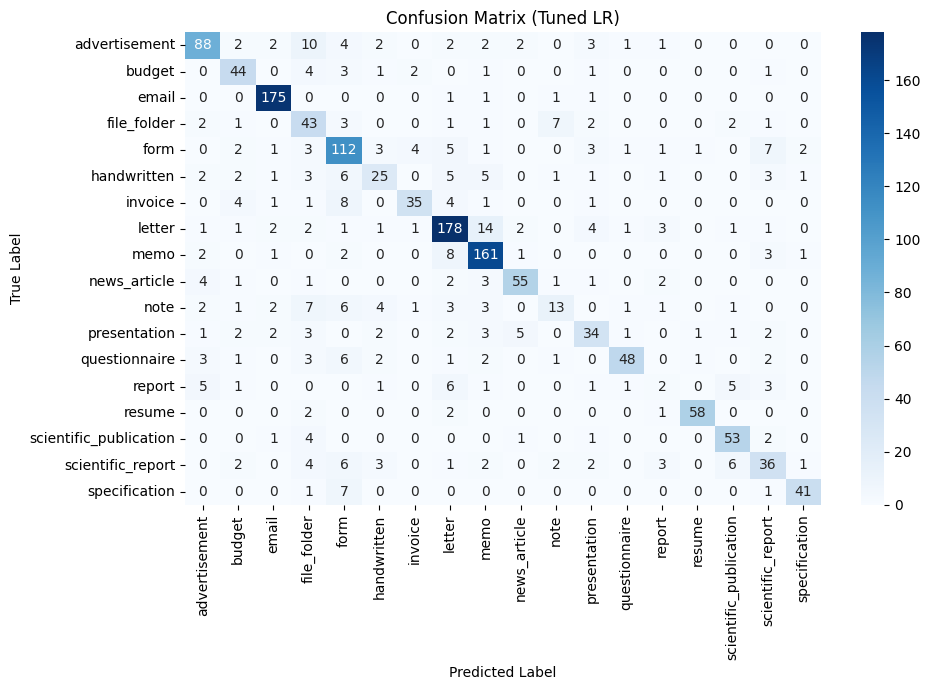

<Figure size 640x480 with 0 Axes>

In [7]:
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix (Tuned LR)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

plt.savefig('confusion_matrix_tuned_lr.png')

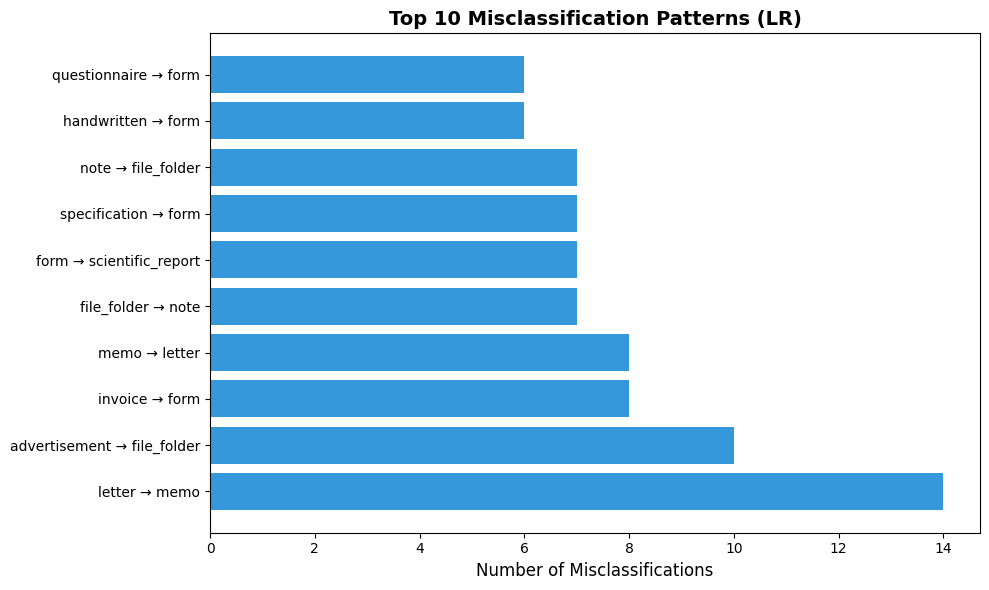

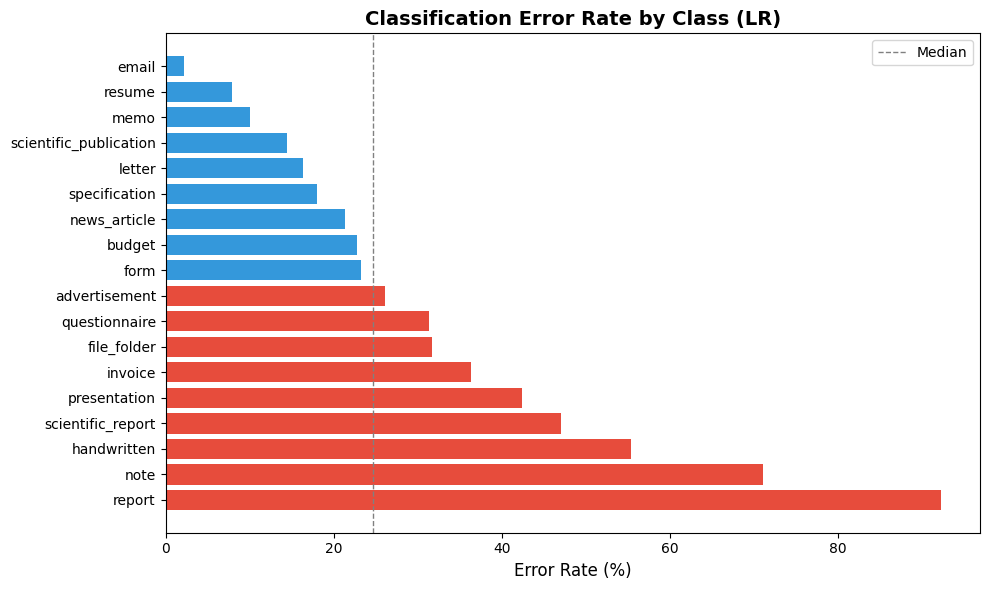

In [8]:
# Get misclassified samples
y_pred_tuned = best_model.predict(X_test)
misclassified_mask = y_test != y_pred_tuned
misclassified_indices = np.where(misclassified_mask)[0]

misclass_df = pd.DataFrame({
    'true_label': [class_names[y_test[i]] for i in misclassified_indices],
    'predicted_label': [class_names[y_pred_tuned[i]] for i in misclassified_indices]
})

misclass_pairs = misclass_df.groupby(['true_label', 'predicted_label']).size().reset_index(name='count')
misclass_pairs = misclass_pairs.sort_values('count', ascending=False)

plt.figure(figsize=(10, 6))
top_pairs = misclass_pairs.head(10)
plt.barh(range(len(top_pairs)), top_pairs['count'], color='#3498db')
plt.yticks(range(len(top_pairs)), 
           [f"{row['true_label']} → {row['predicted_label']}" 
            for _, row in top_pairs.iterrows()])
plt.xlabel('Number of Misclassifications', fontsize=12)
plt.title('Top 10 Misclassification Patterns (LR)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('presentation_misclass_patterns_lr.png', dpi=300, bbox_inches='tight')
plt.show()

error_by_class = pd.DataFrame({
    'Class': class_names,
    'Total': [np.sum(y_test == i) for i in range(len(class_names))],
    'Errors': [np.sum((y_test == i) & (y_pred_tuned != i)) for i in range(len(class_names))],
})
error_by_class['Error Rate (%)'] = (error_by_class['Errors'] / error_by_class['Total'] * 100).round(1)
error_by_class = error_by_class.sort_values('Error Rate (%)', ascending=False)

plt.figure(figsize=(10, 6))
colors = ['#e74c3c' if x > error_by_class['Error Rate (%)'].median() else '#3498db' 
          for x in error_by_class['Error Rate (%)']]
plt.barh(error_by_class['Class'], error_by_class['Error Rate (%)'], color=colors)
plt.xlabel('Error Rate (%)', fontsize=12)
plt.title('Classification Error Rate by Class (LR)', fontsize=14, fontweight='bold')
plt.axvline(error_by_class['Error Rate (%)'].median(), color='gray', linestyle='--', 
            linewidth=1, label='Median')
plt.legend()
plt.tight_layout()
plt.savefig('presentation_error_by_class_lr.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# feature analysis
tuned_vectorizer = best_model.named_steps['tfidf']
tuned_clf = best_model.named_steps['clf']
feature_names = np.array(tuned_vectorizer.get_feature_names_out())

top_n = 10
for i, class_label in enumerate(class_names):
    # get and print top weights and features
    coefficient = tuned_clf.coef_[i]
    top_indices = np.argsort(coefficient)[-top_n:]
    top_features = feature_names[top_indices]
    top_weights = coefficient[top_indices]
    print(f"Top features for class '{class_label}':")
    for feature, weight in zip(top_features, top_weights):
        print(f"{feature}: {weight:.4f}")

Top features for class 'advertisement':
kings: 3.2512
ve: 3.2568
chevrolet: 3.3835
come: 3.4576
camel: 3.5728
music: 4.1571
pleasure: 4.3634
camels: 4.3913
advertisement: 5.3397
Top features for class 'budget':
media: 3.2495
65: 3.3853
march: 3.4044
kool: 3.4078
tobacco institute: 3.4096
project: 3.9560
00: 4.4658
000: 5.1791
budget: 5.2510
total: 6.3261
Top features for class 'email':
br: 3.9496
bravo: 4.0272
1999: 4.0325
pm subject: 4.6894
message: 4.8537
pm: 5.0651
original message: 5.2749
cc: 6.2144
sent: 9.5133
subject: 12.7786
Top features for class 'file_folder':
ets: 1.9171
1964: 1.9627
book: 2.0918
research development: 2.2746
005: 2.3338
ph: 2.3696
presentations: 2.3775
ctr: 2.4531
boy: 2.4673
correspondence: 3.9606
Top features for class 'form':
type: 4.1673
location: 4.1794
transmission: 4.2180
number: 4.3608
telefax: 4.3952
facsimile: 4.5048
datum: 5.2526
form: 6.2351
fax: 6.6945
date: 10.7638
Top features for class 'handwritten':
writing: 3.4704
coupons: 3.5008
paper: 3.5

In [10]:
# save model
import joblib
joblib.dump(best_model, 'lr_tuned.pkl')

['lr_tuned.pkl']